In [6]:
import pymongo as pm
import gridfs
import cPickle
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab

from scipy import misc
import os
import time

import jupyter_utils as utils
from instance_stats import analysis
reload(utils)

<module 'jupyter_utils' from 'jupyter_utils.py'>

In [2]:
def traj_data_paths(name):
    path = '/mnt/fs3/azhai/trajectories/%s.npy' % name
    pca_path = '/mnt/fs3/azhai/trajectories/%s_pca.npy' % name
    return path, pca_path

def smooth(vals, conv_len=10):
    conv_list = np.ones([conv_len])/conv_len
    return np.convolve(vals, conv_list, mode='valid')

class TrajectoryData(object):
    @staticmethod
    def load(loadpath):
        traj_path, traj_pca_path = traj_data_paths(loadpath)
        all_trajectories = np.load(traj_path)
        pca_info = np.load(traj_pca_path)
        print 'loaded', loadpath
        return TrajectoryData(all_trajectories, pca_info)
        
    def __init__(self, all_trajectories, pca_info):
        self.all_trajectories = all_trajectories
        self.smoothed_trajectories = np.apply_along_axis(smooth, axis=0, arr=self.all_trajectories)
        
        self.pca_info = pca_info
        if pca_info is not None:
            assert self.pca_info[0]['principal_vecs'].shape == (10, 128)
            self.pca_vecs = np.array([x['principal_vecs'] for x in self.pca_info])
    
    def get(self, idx):
        return np.take(self.all_trajectories, idx, axis=1)
    
    def get_smoothed(self, idx):
        return np.take(self.smoothed_trajectories, idx, axis=1)

control_traj = TrajectoryData.load('traj_train0')
control_valid_traj = TrajectoryData.load('traj_valid0')
bigcrop_traj = TrajectoryData.load('bigcrop/traj_train0')
small_traj = TrajectoryData.load('small/small_traj_train0')

loaded traj_train0
loaded traj_valid0
loaded bigcrop/traj_train0
loaded small/small_traj_train0


In [ ]:
#trajectory_diffs = control_traj.smoothed_trajectories[10:] - control_traj.smoothed_trajectories[:-10]
trajectory_diffs = control_traj.all_trajectories[1:] - control_traj.all_trajectories[:-1]
trajectory_diff_sizes = np.linalg.norm(trajectory_diffs, axis=-1)

mean_displacements = np.mean(trajectory_diff_sizes, axis=1)
print mean_displacements.shape
plt.plot(range(len(mean_displacements)), mean_displacements)    
plt.show()

plt.hist(trajectory_diff_sizes[80], bins=30)
plt.show()

In [ ]:
vweights = [info['variance_weights'] for info in control_traj.pca_info]
plt.bar(range(10), np.mean(vweights, axis=0))
#plt.bar(range(1, 10), np.mean(vweights, axis=0)[1:])

weights_mean = np.mean(vweights, axis=0)
print weights_mean
print 'variance explained by top 10 principal vectors (avg over training examples):'
print sum(weights_mean)
print 'variance explained by 2nd-10th principal vectors after excluding top (avg over training examples):'
print sum(weights_mean[1:]) / (1 - weights_mean[0]) 

In [19]:
# trajectory of resnet weights
weight_traj = np.load('/mnt/fs3/azhai/trajectories/weight_trajectory.npz')
def get_flattened(key):
    ret = [np.ndarray.flatten(x) for x in weight_traj[key]]
    return np.array(ret)

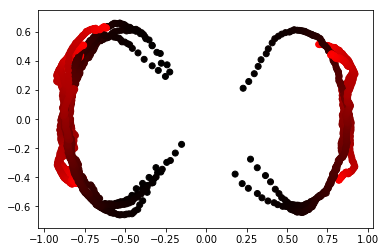

In [18]:
comps = (0,1)

for i in range(10):
    utils.plot_trajectory(control_traj.get(i), plt, components=comps,
                          projection_vecs=control_traj.pca_vecs[i])